In [83]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [84]:
import numpy as np
import pandas as pd

In [85]:
import datetime as dt
import datetime
from datetime import date, timedelta

# Reflect Tables into SQLAlchemy ORM

In [86]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [87]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [88]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [89]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [90]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [91]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [92]:
inspector=inspect(engine)
inspector.get_table_names()
measurement_data=inspector.get_columns("measurement")
for x in measurement_data:
    print(x["name"],x["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Climate Analysis

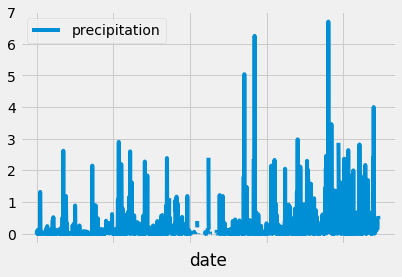

In [93]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from today
dates= engine.execute("SELECT date FROM Measurement ORDER BY date desc").first()
dates
date_on_year=datetime.datetime.now() - datetime.timedelta(days=365)
date_on_year

# Perform a query to retrieve the data and precipitation scores
precipitation_data=session.query(Measurement.date, Measurement.prcp).filter(Measurement.date>="2016-08-23").filter(Measurement.date<="2017-08-23").all()
precipitation_data
# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df=pd.DataFrame(precipitation_data).set_index("date").rename(columns={"prcp":"precipitation"})
precip_df.head()
# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data

# x_axis=np.arange(len("date"))
# plt.bar(x_axis, prcp)

precip_bar=precip_df.plot(rot=45 )
# Rotate the xticks for the dates



In [94]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [95]:
station_data=inspector.get_columns("station")
for x in station_data:
    print(x["name"],x["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [96]:
# How many stations are available in this dataset?
stations=session.query(Station.id).count()
stations

9

In [97]:
# What are the most active stations?
# List the stations and the counts in descending order.
# active_stations=session.query(Station.station, func.count(Station.station)).group_by(Station.station).order_by(func.count(Station.station).desc()).all()
# active_stations

active_stations=session.query(Station.station, func.count(Measurement.tobs)).filter(Measurement.station==Station.station).group_by(Station.station).order_by(func.count(Measurement.tobs).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [98]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

lowest_temp=session.query(Measurement.tobs).filter(Station.station=="USC00519281").order_by(Measurement.tobs.asc()).first()
highest_temp=session.query(Measurement.tobs).filter(Station.station=="USC00519281").order_by(Measurement.tobs.desc()).first()
avg_temp=session.query(func.avg(Measurement.tobs)).first()
temp_data=lowest_temp, highest_temp, avg_temp
temp_data


((53.0), (87.0), (73.09795396419437))

(array([ 10.,  17.,  66.,  85., 258., 246., 291., 593., 356., 287.,  18.,
          3.]),
 array([58.        , 60.41666667, 62.83333333, 65.25      , 67.66666667,
        70.08333333, 72.5       , 74.91666667, 77.33333333, 79.75      ,
        82.16666667, 84.58333333, 87.        ]),
 <a list of 12 Patch objects>)

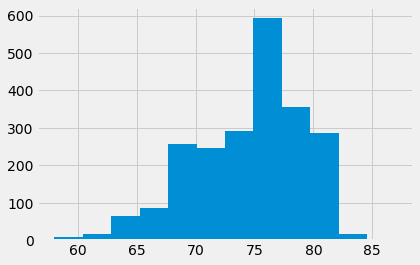

In [99]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
twelve_months=session.query(Measurement.tobs).filter(Measurement.date>="2016-08-23").filter(Station.station=="USC00519281").all()
twelve_months_df=pd.DataFrame(twelve_months)
twelve_months_df.head()

plt.hist(twelve_months_df["tobs"], bins=12)



In [100]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


In [101]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [102]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

temp_calcs=calc_temps("2011-02-28","2011-03-05")


temp_calcs

[(61.0, 69.75510204081633, 75.0)]

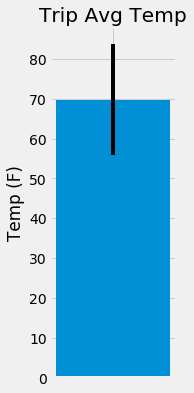

In [103]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

def calc_temps(start_date, end_date):
    dates=session.query(Measurement.date, Measurement.tobs).filter(Measurement.date>=start_date).filter(Measurement.date<=end_date).all()
    dates_df=pd.DataFrame(dates)
    mean_temp=dates_df["tobs"].mean()
    min_temp=dates_df["tobs"].min()
    max_temp=dates_df["tobs"].max()
    mean_temp
    plt.figure(figsize=(2,6))
    plt.bar(1, mean_temp, yerr=max_temp-min_temp, tick_label="")
    plt.title("Trip Avg Temp")
    plt.ylabel("Temp (F)")
    plt.show()
calc_temps("2011-02-28","2011-03-05")

In [104]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
dates=session.query(Measurement.prcp, Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).filter(Measurement.date>="2011-02-08").filter(Measurement.date<="2012-02-08").order_by(Measurement.prcp.desc()).all()
dates_df=pd.DataFrame(dates)
dates_df.head()




,prcp,station,name,latitude,longitude,elevation
0,6.42,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,6.42,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,6.42,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,6.42,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,6.42,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


## Optional Challenge Assignment

In [105]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [106]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [107]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [108]:
# Plot the daily normals as an area plot with `stacked=False`
